### Data Visualizations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

jobs = pd.read_csv('../data/processed/jobs.csv')
apartments = pd.read_csv('../data/processed/apartments.csv')

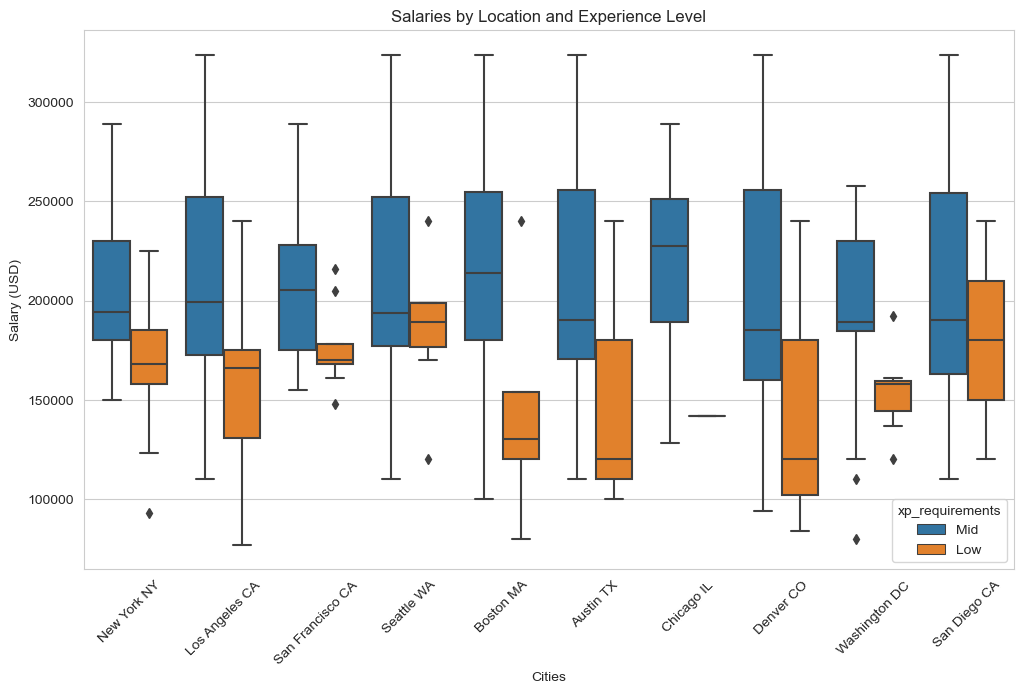

In [2]:
#Boxplots for Salary Data

sns.set_style('whitegrid')
plt.figure(figsize=[12,7])
sns.boxplot(x=jobs['locations'], y=jobs['salaries'], hue=jobs['xp_requirements'])
plt.title('Salaries by Location and Experience Level')
plt.xlabel('Cities')
plt.xticks(rotation=45)
plt.ylabel('Salary (USD)');

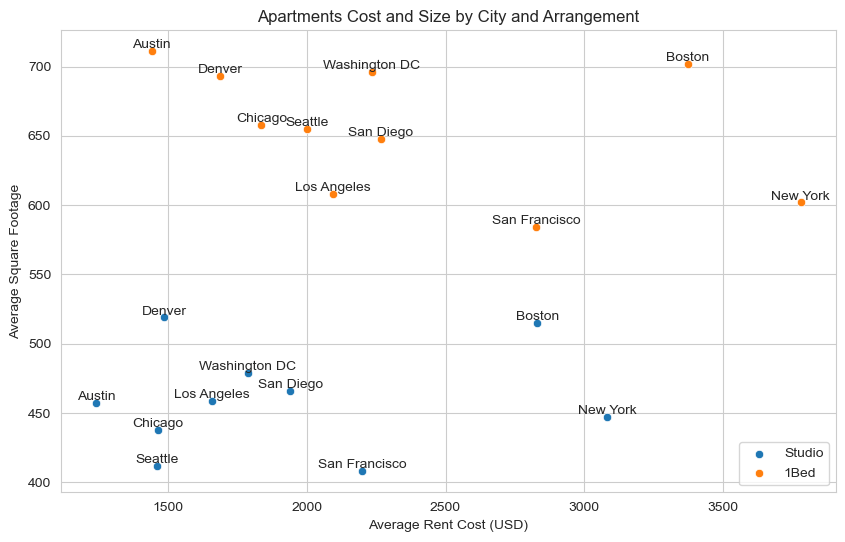

In [3]:
#Scatter Plots for Apartment Data
plt.figure(figsize=[10,6])
sns.scatterplot(x=apartments['Avg Rent Studio'], y=apartments['Sqr Ft Studio'], label='Studio')
sns.scatterplot(x=apartments['Avg Rent 1Bed'], y=apartments['Avg Sqr Ft 1Bed'], label='1Bed')

i = 0
for city in apartments['Location']:
    plt.text(apartments['Avg Rent Studio'][i], apartments['Sqr Ft Studio'][i], city, ha= 'center', va='bottom')
    plt.text(apartments['Avg Rent 1Bed'][i], apartments['Avg Sqr Ft 1Bed'][i], city, ha= 'center', va='bottom')
    i += 1
plt.title('Apartments Cost and Size by City and Arrangement')
plt.xlabel('Average Rent Cost (USD)')
plt.ylabel('Average Square Footage')
plt.legend(loc='lower right');

In [4]:
joined_data = pd.read_csv('../data/processed/joined_data.csv')

joined_data['disposable_income'] = (joined_data['salaries'])-(joined_data['Est. Income Taxes'])-(joined_data['Avg Rent 1Bed']*12)

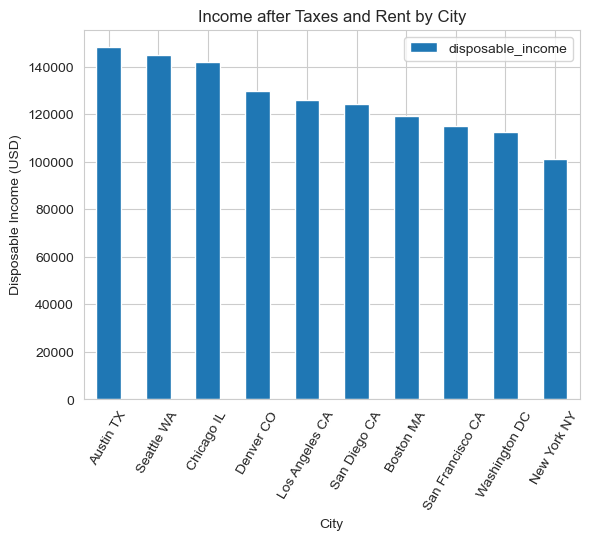

In [5]:
#Disposable Income by City

spending = pd.DataFrame(joined_data['disposable_income'].groupby(joined_data['locations']).mean().round())
sorted_1 = spending.sort_values(by='disposable_income', ascending=False)

sorted_1.plot.bar()
plt.title('Income after Taxes and Rent by City')
plt.xlabel('City')
plt.ylabel('Disposable Income (USD)')
plt.xticks(rotation=60);

In [6]:
#Distance from Home
from amadeus import Client, ResponseError
from amadeus import Location

key = 'Rn1PiL5VmnsTsj2glfvLBgmRgmgl9lnP'
secret = 'iUpqGrVZ3NPk52Rt'

amadeus = Client(
    client_id=key,
    client_secret=secret)

try:
    airport_input = input('Please input an IATA Airport Code. \n')
    
    output1 = amadeus.airport.direct_destinations.get(departureAirportCode=airport_input, arrivalCountryCode ='US')
    flight_routes = pd.DataFrame(output1.data)
    
    output2 = amadeus.reference_data.locations.get(subType=Location.AIRPORT,keyword=airport_input)
    airport_info = pd.DataFrame(output2.data)
except ResponseError as error:
    raise error

Please input an IATA Airport Code. 
MCO


In [7]:
#Calculating distance between two lat/long points
#Source: https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/

import math

def haversine(lat1, lon1, lat2, lon2):
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

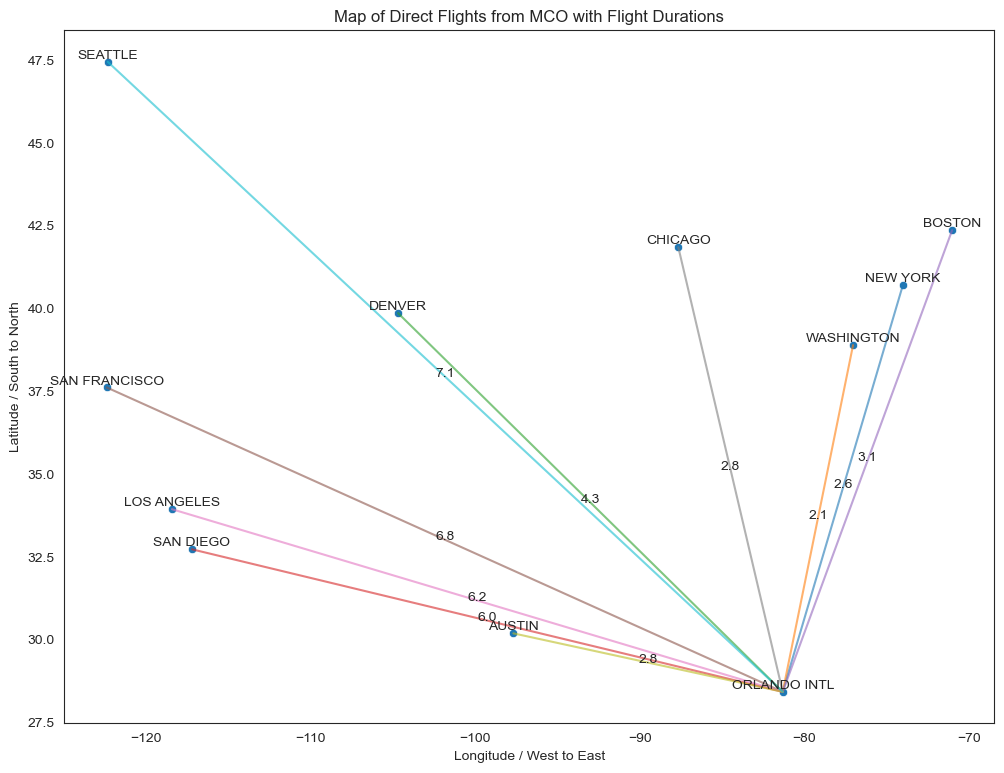

In [8]:
airport_codes = ['NYC','WAS','DEN','SAN','BOS','SFO','LAX','CHI','AUS','SEA']
list1 = []
list2 = []

for i in range(len(airport_codes)):
    list1.append(flight_routes[flight_routes['iataCode'] == airport_codes[i]]['name'].tolist())
    list2.append(flight_routes[flight_routes['iataCode'] == airport_codes[i]]['geoCode'].tolist())
list1.append(airport_info['name'].tolist())
list2.append(airport_info['geoCode'].tolist())


for i in range(len(list1)):
    if len(list1[i])>1:
        list1[i] = list1[i][1]
        list2[i] = list2[i][1]
    elif len(list1[i])==1:
        list1[i] = list1[i][0]
        list2[i] = list2[i][0]
    else: 
        list1[i] = i
        list2[i] = 'NA'

airport_df = pd.DataFrame()
airport_df['city'] = list1
airport_df['geoCode'] = list2

list3 = []
list4 = []

for i in range(len(airport_df)):
    try:
        list3.append(airport_df['geoCode'][i]['latitude'])
        list4.append(airport_df['geoCode'][i]['longitude'])
    except:
        list3.append('NA')
        list4.append('NA')

airport_df['lat'] = list3
airport_df['long'] = list4

distances = []

for i in range(len(airport_df[:-1])):
    if airport_df['lat'][i] == 'NA':
        distances.append('N/A')
    else:
        distances.append(round(((haversine(airport_df['lat'][i],airport_df['long'][i],
                                airport_df['lat'][10],airport_df['long'][10]))/575),1))
distances.append('NA')

airport_df['Flight Duration'] = distances
airport_df = airport_df[airport_df['geoCode'] != 'NA']
airport_df.index = range(len(airport_df))

plt.figure(figsize=[12,9])
sns.set_style('white')
sns.scatterplot(x=airport_df['long'].astype('float'),y=airport_df['lat'].astype('float'))
    
for i in range(len(airport_df)):
    plt.text(airport_df['long'][i], airport_df['lat'][i], airport_df['city'][i], ha= 'center', va='bottom')
for i in range(len(airport_df)-1):
    plt.plot([airport_df['long'].iloc[-1],airport_df['long'].iloc[i]],
             [airport_df['lat'].iloc[-1],airport_df['lat'].iloc[i]], '-', alpha=.6)
    plt.text((airport_df['long'].iloc[-1]+airport_df['long'].iloc[i])/2, 
             (airport_df['lat'].iloc[-1]+airport_df['lat'].iloc[i])/2, airport_df['Flight Duration'][i],ha='center')
plt.title('Map of Direct Flights from ' + str(airport_input) + ' with Flight Durations')
plt.ylabel('Latitude / South to North')
plt.xlabel('Longitude / West to East');